# Timeseries for the capstone project

In [30]:
# importing related module and function
import re, io
import os, json
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
from fbprophet.plot import plot_cross_validation_metric
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from time_series import *
from pandas._libs.tslibs import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
DATA_DIR = os.path.join("..", "data/cs-train")

plt.style.use('seaborn')
%matplotlib inline

In [4]:
df = pd.DataFrame()

data_filenames = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
data_filenames = sorted(data_filenames)

for filename in data_filenames:
    invoice_filename = os.path.join(DATA_DIR, filename)
    invoice_df = pd.read_json(invoice_filename)
    
    # Rename column names where applicable
    invoice_df = invoice_df.rename(columns={
        'total_price': 'price',
        'StreamID': 'stream_id',
        'TimesViewed': 'times_viewed'
    })
    
    df = df.append(invoice_df)


# Set country to a categorical type
df['country'] = df['country'].astype('category')
df['invoice'] = df['invoice'].astype('category')
df['customer_id'] = df['customer_id'].astype('category')
df['stream_id'] = df['stream_id'].astype('category')
# Drop - price error from database
df=df[df["price"]>0]
df = df.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df= create_date_col(df)
# Remove outlier
df= df[df['price']<=20000]

df.head()

,year,month,day,times_viewed,price,country,Date
0,2017,11,28,15018,14450.54,United Kingdom,2017-11-28
1,2017,11,29,14110,13411.96,United Kingdom,2017-11-29
2,2017,11,30,15685,13290.25,United Kingdom,2017-11-30
3,2017,12,1,12505,9687.28,United Kingdom,2017-12-01
4,2017,12,2,3310,1443.26,United Kingdom,2017-12-02


## Iteration on possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

<AxesSubplot:>

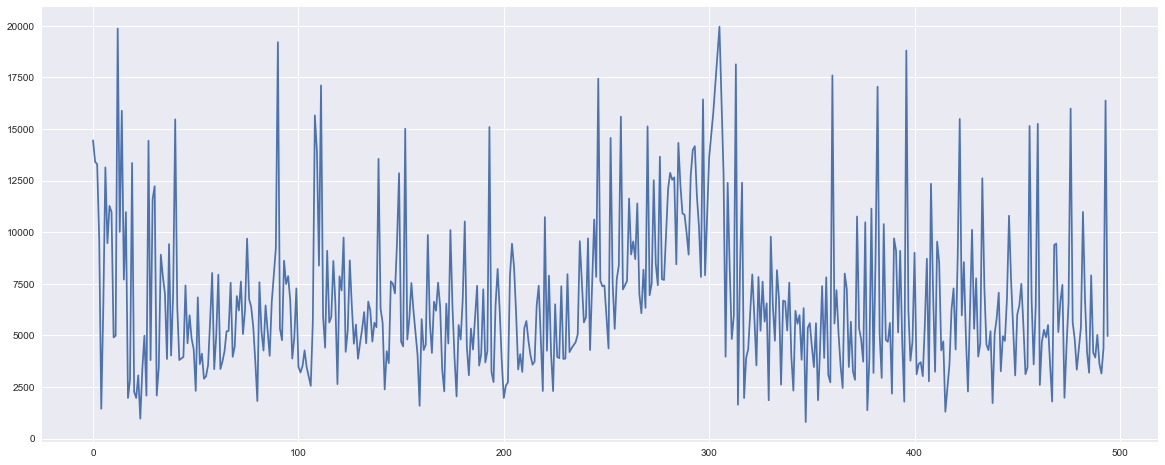

In [7]:
# Ploting timeseries
ts_day= df['price']
ts_day.plot(figsize=(20, 8))

<AxesSubplot:>

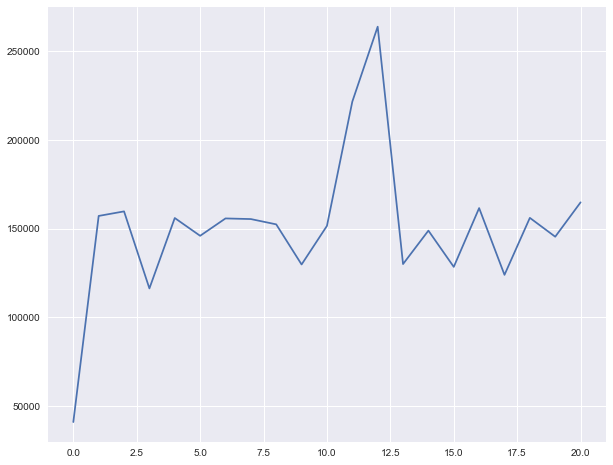

In [8]:
# time-series on a monthly basis
df_month = df.groupby(['year', 'month']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
ts_month = df_month['price']
ts_month.plot(figsize=(10, 8));

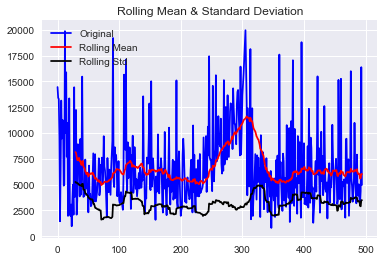

Results of Dickey-Fuller Test:
Test Statistic                  -5.446305
p-value                          0.000003
#Lags Used                       5.000000
Number of Observations Used    468.000000
Critical Value (1%)             -3.444400
Critical Value (5%)             -2.867736
Critical Value (10%)            -2.570070
dtype: float64


In [9]:
test_stationarity(ts_day)

### Fitting ARIMA time series model to untransformed data

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


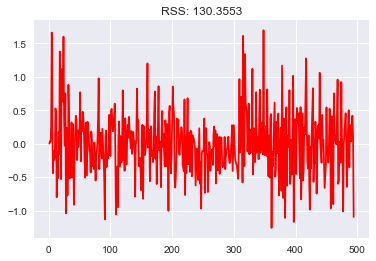

In [12]:
fit_ARIMA(ts_day, (1,1,1))

### Decomposing the time series into trend, seasonality and residuals

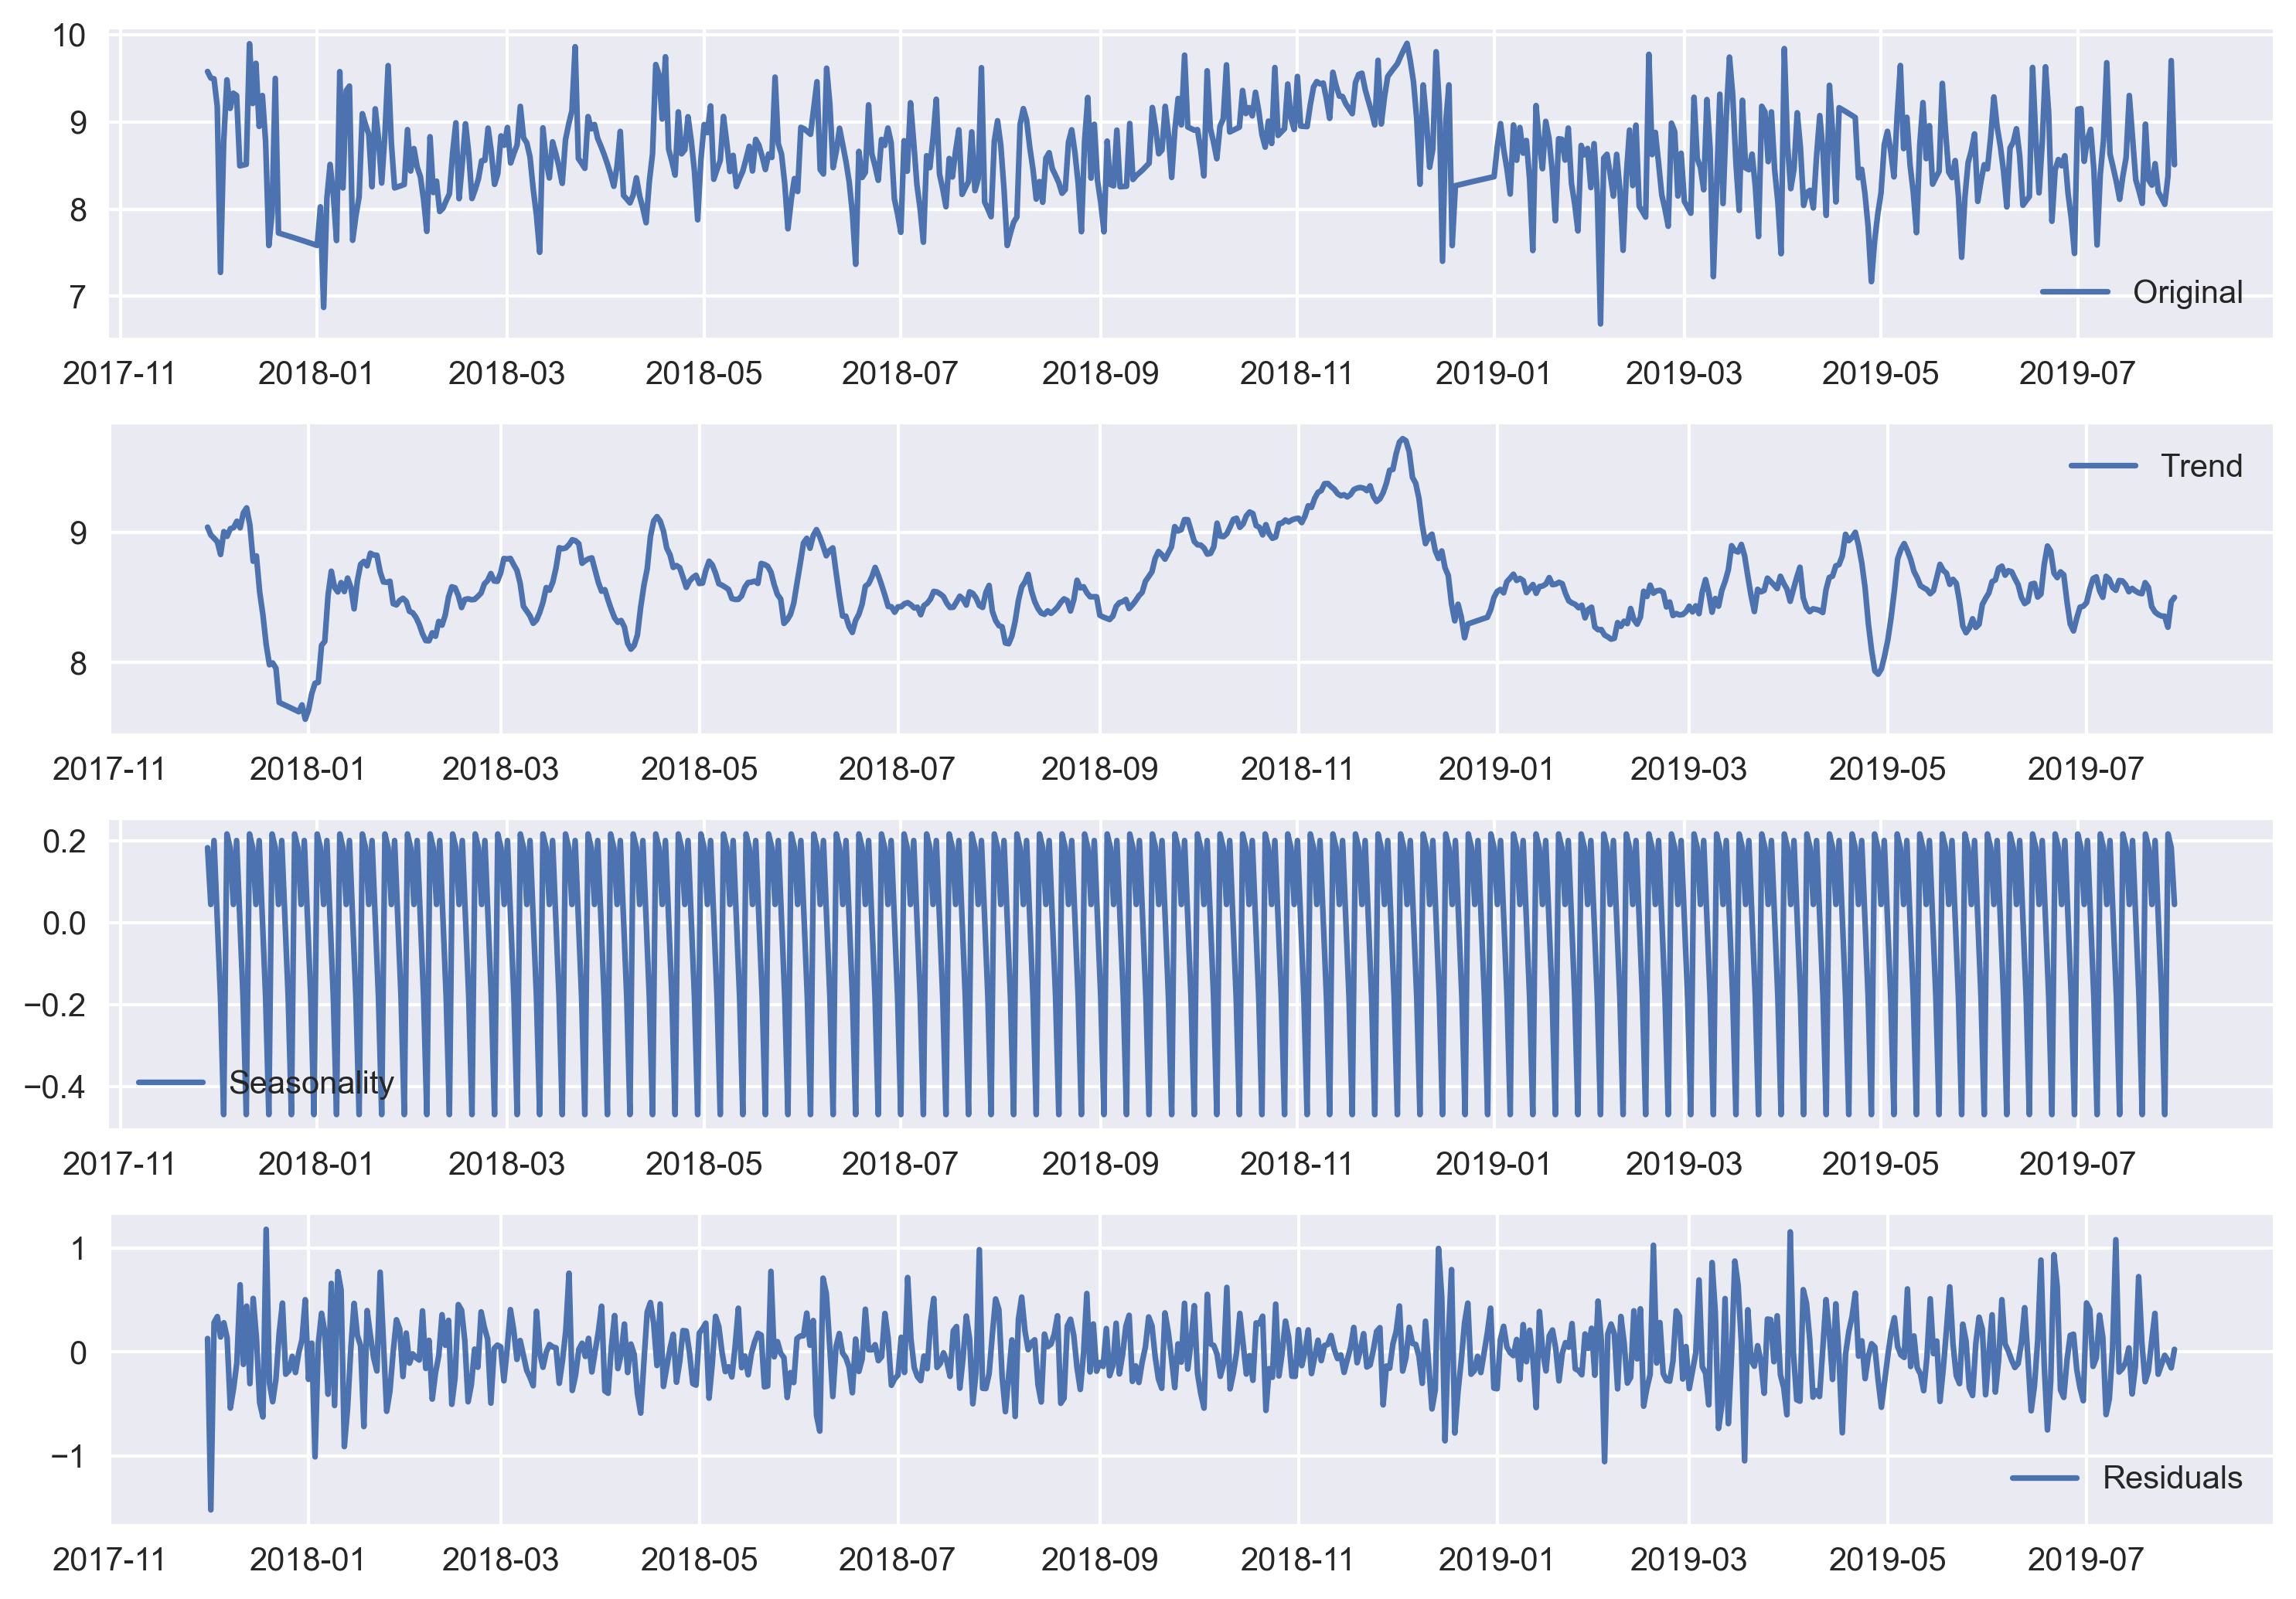

In [13]:
# Fill the missing datas to make data continuous and compatible with decompose function
ts = make_continuous(df)
## Decompose the data into trend, seasonality and residual
trend, seasonal, residual = decompose(ts, 'price')

### Log transforming data and calculating ACF, PACF for ARIMA model

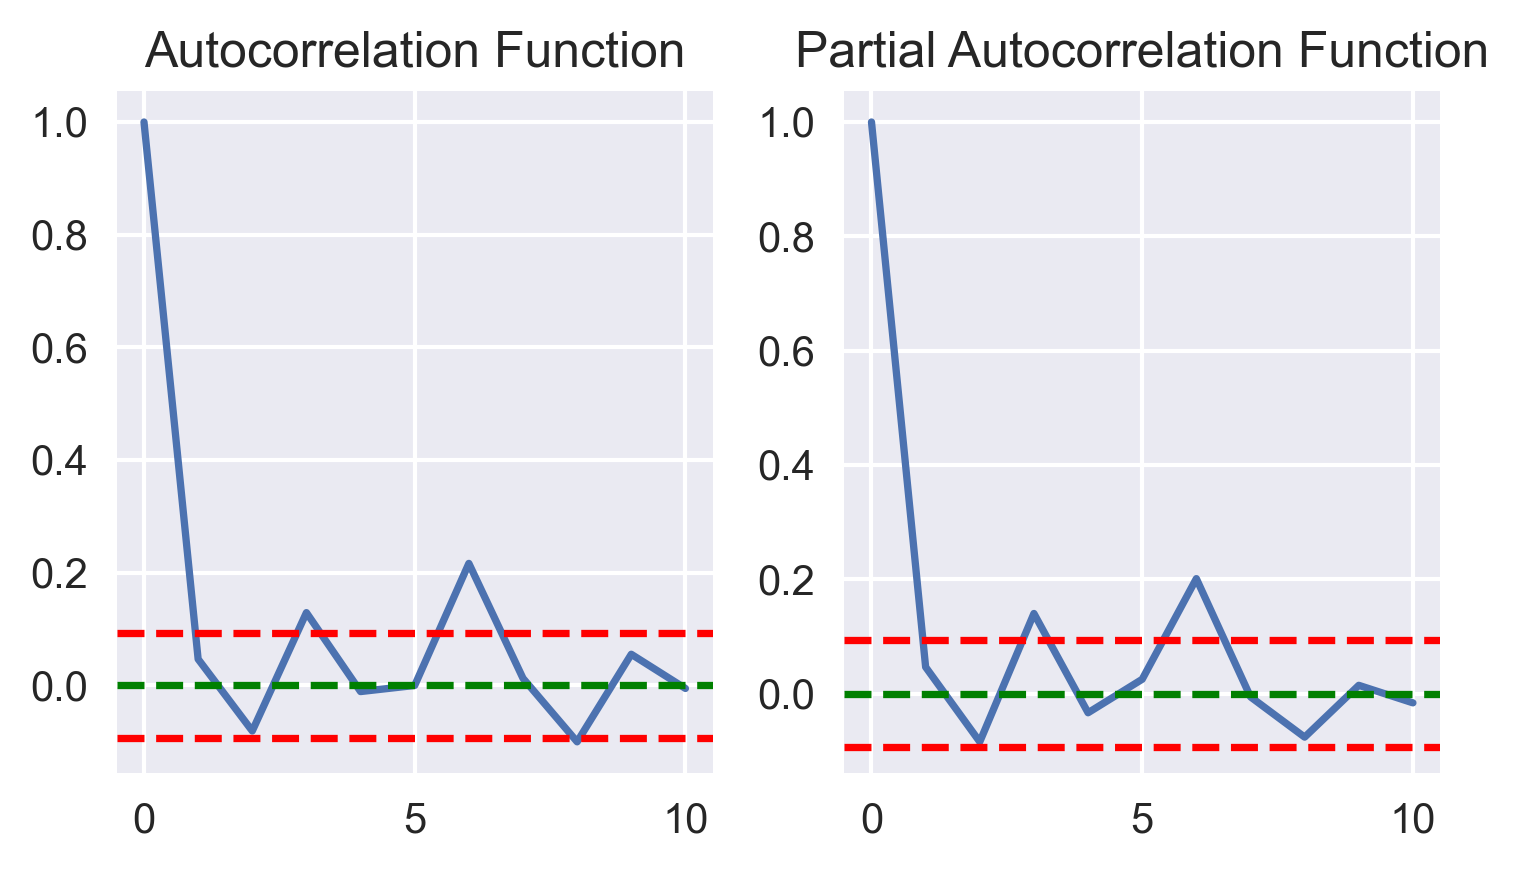

In [14]:
ACF_PACF(ts_day)

### Fitting ARIMA model to the log transformed data

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


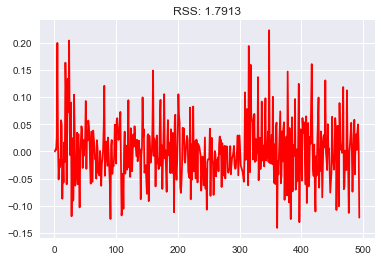

In [15]:
# ts_transformed = transform(ts_day, 30)
ts_transformed, ts_log_diff = log_shift(ts_day, 30)
fitted = fit_ARIMA(ts_transformed, (1,1,1))

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


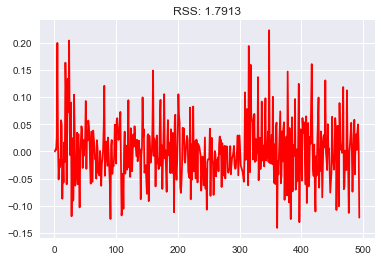

In [16]:
predictions = predict_ARIMA(ts_transformed, (1,1,1))

In [17]:
predictions.head()

1   -0.000083
2    0.003670
3    0.002989
4    0.026583
5    0.199531
dtype: float64

In [18]:
ts_transformed.head()

0    9.578487
1    9.503902
2    9.494786
3    9.178569
4    7.274660
Name: price, dtype: float64

In [19]:
predictions_ARIMA_diff_cumsum = predictions.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1   -0.000083
2    0.003587
3    0.006575
4    0.033159
5    0.232690
dtype: float64


In [21]:
predictions_ARIMA_log = pd.Series(ts_transformed[0], index=ts_transformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    9.578487
1    9.578404
2    9.582074
3    9.585063
4    9.611646
dtype: float64

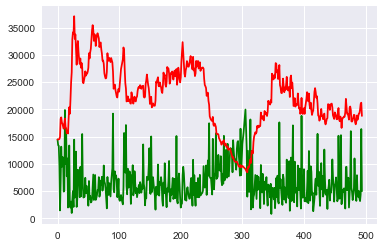

In [22]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_day, color='green')
plt.plot(predictions_ARIMA, color='red')

## Prophet Prediction

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,8010.0,5338.0,12630.0,8010.0,8010.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,0.0,0.0,0.0,9052.0
1,2017-11-29,7948.0,4254.0,12109.0,7948.0,7948.0,209.0,209.0,209.0,209.0,209.0,209.0,0.0,0.0,0.0,8158.0
2,2017-11-30,7886.0,5200.0,12738.0,7886.0,7886.0,1155.0,1155.0,1155.0,1155.0,1155.0,1155.0,0.0,0.0,0.0,9042.0
3,2017-12-01,7825.0,3886.0,11426.0,7825.0,7825.0,-55.0,-55.0,-55.0,-55.0,-55.0,-55.0,0.0,0.0,0.0,7770.0
4,2017-12-02,7763.0,2475.0,10504.0,7763.0,7763.0,-1313.0,-1313.0,-1313.0,-1313.0,-1313.0,-1313.0,0.0,0.0,0.0,6449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,5951.0,2447.0,12058.0,2484.0,8805.0,1382.0,1382.0,1382.0,1382.0,1382.0,1382.0,0.0,0.0,0.0,7332.0
707,2019-11-05,5951.0,1395.0,11560.0,2431.0,8844.0,1042.0,1042.0,1042.0,1042.0,1042.0,1042.0,0.0,0.0,0.0,6994.0
708,2019-11-06,5952.0,1151.0,10784.0,2381.0,8880.0,209.0,209.0,209.0,209.0,209.0,209.0,0.0,0.0,0.0,6161.0
709,2019-11-07,5952.0,1918.0,11867.0,2317.0,8941.0,1155.0,1155.0,1155.0,1155.0,1155.0,1155.0,0.0,0.0,0.0,7107.0


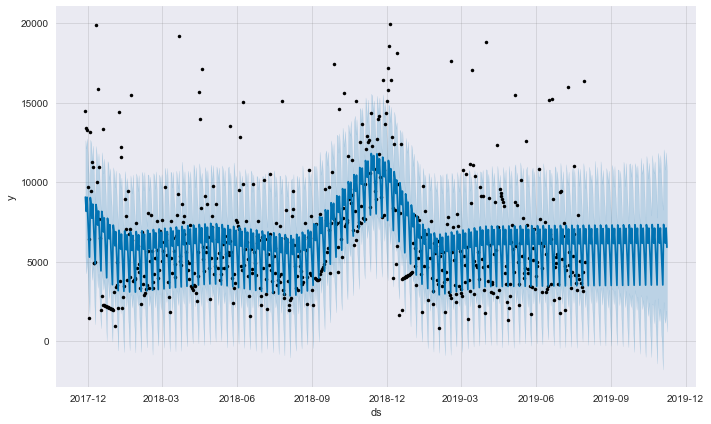

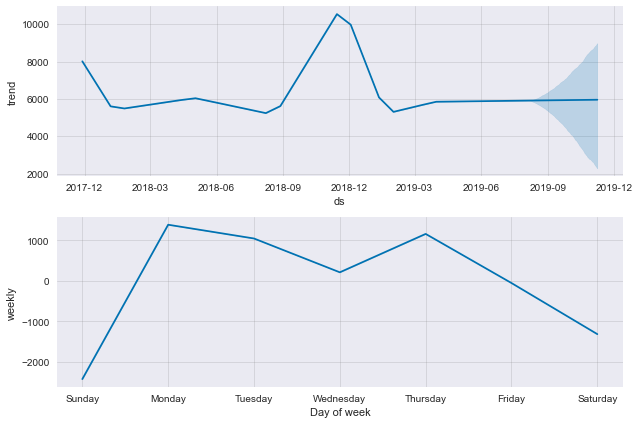

In [23]:
prophet_forecast(df, 100)

In [24]:
m = Prophet()
ts = make_continuous(df)
df = pd.DataFrame()
df['ds'] = ts.index
df['y'] = ts.price.values
m.fit(df)
future = m.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [25]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
636,2019-08-26,6740.196540,2639.772207,11035.103856
637,2019-08-27,6417.467939,2237.804842,10596.052710
638,2019-08-28,5575.391924,1465.024366,9640.195845
639,2019-08-29,6505.170727,1962.285461,10396.335523
640,2019-08-30,5285.228807,741.375865,9168.256970


In [28]:
df_cv = cross_validation(m, initial='500 days', period='150 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-22 00:00:00 and 2019-04-22 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-23,7103.784081,3070.128536,11221.885758,8523.900000,2019-04-22
1,2019-04-24,6349.066528,2265.606825,10515.659653,4271.070000,2019-04-22
2,2019-04-25,7511.285481,3054.799131,11986.868023,4706.130000,2019-04-22
3,2019-04-26,6210.160254,1878.118159,10580.921287,3570.223333,2019-04-22
4,2019-04-27,4933.807596,771.772681,9196.253152,2434.316667,2019-04-22


In [29]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,9.179678e+06,3029.798409,2772.752099,1.012394,0.746759,0.8
1,11 days,9.101607e+06,3016.887018,2741.916854,1.011013,0.746759,0.8
2,12 days,8.752340e+06,2958.435324,2624.968313,0.978034,0.746759,0.8
3,13 days,7.992870e+06,2827.166353,2396.816635,0.930558,0.746759,0.8
4,14 days,7.426327e+06,2725.128798,2247.008789,0.869671,0.474604,0.8


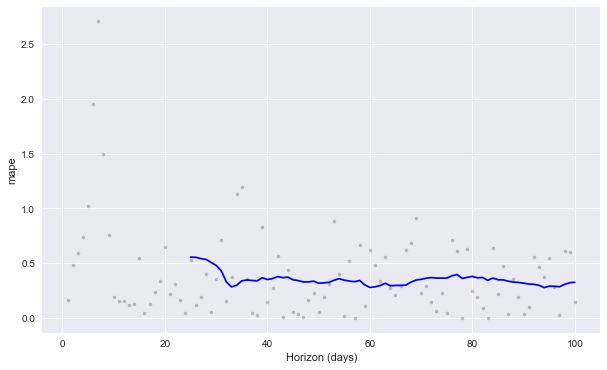

In [31]:
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.25)